# 3. Mastery Map Visualization

This notebook demonstrates how to create and interpret a **Mastery Map** - a visual representation of how different combinations of attempts and successes map to mastery classifications.

## 3.1 What is a Mastery Map?

A mastery map is a **heat map** that shows:
- **X-axis**: Number of attempts
- **Y-axis**: Number of successes
- **Colors**: The classification label (Attempted, Familiar, or Proficient)

**Key Insight**: For any given combination of attempts and successes, the map shows what mastery label would be assigned based on the Beta–Binomial classifier's rules.

This map helps you:
- Understand classification boundaries
- See how sample size affects classifications
- Visualize the impact of different priors and thresholds
- Make informed decisions about classification parameters


## 3.3 Import Libraries and Set Up Parameters

Let's start by importing the necessary libraries:


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

print("Libraries imported successfully!")


Libraries imported successfully!


### Define Parameters

We'll use the same parameters as in the previous notebooks for consistency:


In [11]:
# Prior parameters
alpha_prior = 2.0
beta_prior = 2.0

# Classification thresholds
familiar_threshold = 0.3
proficient_threshold = 0.5

# Confidence level for credible intervals
confidence = 0.8

# Maximum number of attempts to visualize
max_attempts = 20

print("Mastery Map Parameters:")
print(f"  Prior: Beta(α={alpha_prior}, β={beta_prior})")
print(f"  Familiar threshold: {familiar_threshold:.0%}")
print(f"  Proficient threshold: {proficient_threshold:.0%}")
print(f"  Confidence level: {confidence:.0%}")
print(f"  Maximum attempts: {max_attempts}")


Mastery Map Parameters:
  Prior: Beta(α=2.0, β=2.0)
  Familiar threshold: 30%
  Proficient threshold: 50%
  Confidence level: 80%
  Maximum attempts: 20


## 3.4 Helper Functions

Let's define the functions we'll use to build the mastery map:


In [12]:
def posterior_params(alpha_prior, beta_prior, n, k):
    """
    Compute posterior Beta parameters.
    
    Parameters:
    - alpha_prior, beta_prior: Prior parameters
    - n: Number of attempts
    - k: Number of successes
    
    Returns:
    - alpha_post, beta_post: Posterior parameters
    """
    alpha_post = alpha_prior + k
    beta_post = beta_prior + (n - k)
    return alpha_post, beta_post

def ci_low(alpha_post, beta_post, confidence):
    """
    Calculate the lower bound of the credible interval.
    
    Parameters:
    - alpha_post, beta_post: Posterior Beta parameters
    - confidence: Confidence level (e.g., 0.8 for 80%)
    
    Returns:
    - Lower bound of the credible interval
    """
    lower_percentile = (1 - confidence) / 2
    return beta.ppf(lower_percentile, alpha_post, beta_post)

print("Helper functions defined!")
print("  - posterior_params(): Computes posterior Beta parameters")
print("  - ci_low(): Calculates lower bound of credible interval")


Helper functions defined!
  - posterior_params(): Computes posterior Beta parameters
  - ci_low(): Calculates lower bound of credible interval


## 3.5 Building the Mastery Grid

Now we'll build a grid where each cell represents a classification for a specific (attempts, successes) combination:


In [13]:
# Initialize the grid
# We'll use values: 0 = Attempted, 1 = Familiar, 2 = Proficient
grid = np.empty((max_attempts + 1, max_attempts + 1))

# Fill the grid
print("Building mastery grid...")
for n in range(max_attempts + 1):  # n = attempts (0 to max_attempts)
    for k in range(n + 1):  # k = successes (0 to n, since k ≤ n)
        # Compute posterior parameters
        alpha_post, beta_post = posterior_params(alpha_prior, beta_prior, n, k)
        
        # Calculate lower bound of credible interval
        low = ci_low(alpha_post, beta_post, confidence)
        
        # Classify based on lower bound
        if low >= proficient_threshold:
            grid[n, k] = 2  # Proficient
        elif low >= familiar_threshold:
            grid[n, k] = 1  # Familiar
        else:
            grid[n, k] = 0  # Attempted
        
    if (n + 1) % 5 == 0:
        print(f"  Processed {n + 1} attempts...")

print(f"\nGrid completed! Shape: {grid.shape}")
print(f"  Total cells: {grid.shape[0] * grid.shape[1]}")
print(f"  Valid combinations: {sum(range(max_attempts + 2))} (triangular pattern)")


Building mastery grid...
  Processed 5 attempts...
  Processed 10 attempts...
  Processed 15 attempts...
  Processed 20 attempts...

Grid completed! Shape: (21, 21)
  Total cells: 441
  Valid combinations: 231 (triangular pattern)


## 3.6 Visualizing the Mastery Map

Let's create the visualization with proper formatting and labels:


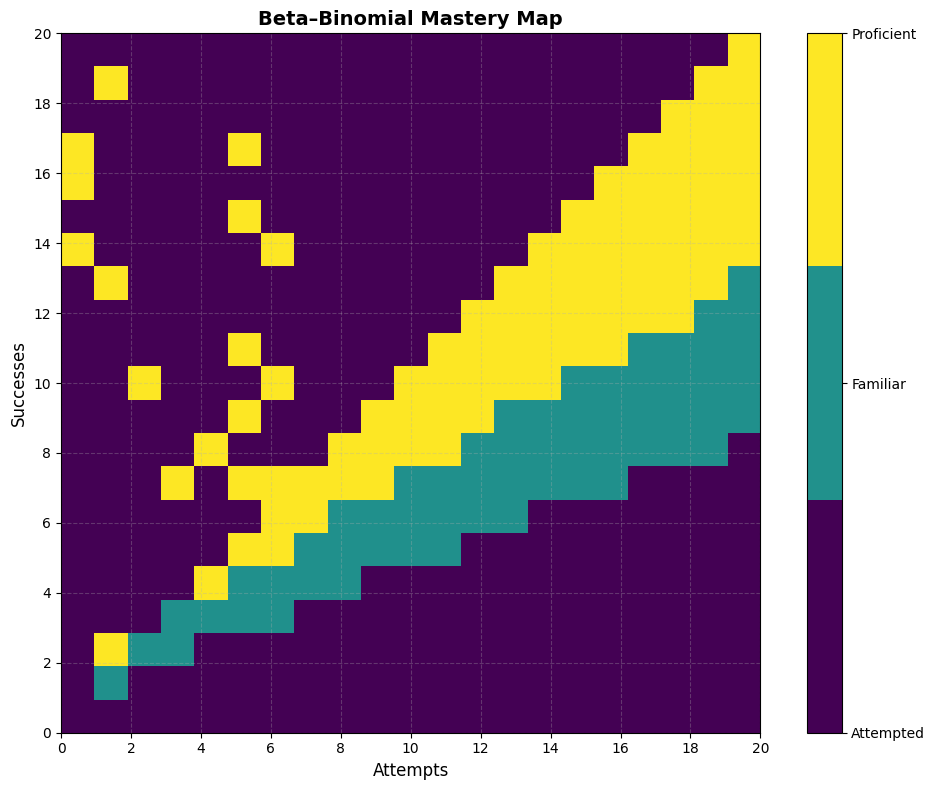


Mastery Map Interpretation:
  - Dark purple (bottom-left): Attempted
  - Teal/Green (middle): Familiar
  - Yellow (top-right): Proficient

  Key Observation: Notice the diagonal bands.
    More attempts with same success rate → higher classification!


In [14]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Use viridis colormap with 3 discrete colors
cmap = plt.get_cmap('viridis', 3)

# Plot the grid
# Note: grid.T transposes so successes are on y-axis
im = ax.imshow(grid.T, origin='lower', 
               extent=[0, max_attempts, 0, max_attempts], 
               aspect='equal', 
               cmap=cmap, 
               vmin=0, vmax=2)

# Set integer ticks only (since attempts and successes are discrete)
tick_step = 2  # Show every 2 integers for max_attempts=20
ticks = np.arange(0, max_attempts + 1, tick_step)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# Add colorbar with labels
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(["Attempted", "Familiar", "Proficient"])

# Labels and title
ax.set_xlabel('Attempts', fontsize=12)
ax.set_ylabel('Successes', fontsize=12)
ax.set_title('Beta–Binomial Mastery Map', fontsize=14, fontweight='bold')

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nMastery Map Interpretation:")
print("=" * 60)
print("  - Dark purple (bottom-left): Attempted")
print("  - Teal/Green (middle): Familiar")
print("  - Yellow (top-right): Proficient")
print("\n  Key Observation: Notice the diagonal bands.")
print("    More attempts with same success rate → higher classification!")


## 3.7 Exploring Specific Examples

Let's look at a few specific examples from the map to understand the classification logic:


In [15]:
# Explore some specific examples
examples = [
    {"attempts": 5, "successes": 2, "description": "40% success rate, few attempts"},
    {"attempts": 5, "successes": 4, "description": "80% success rate, few attempts"},
    {"attempts": 10, "successes": 5, "description": "50% success rate, moderate attempts"},
    {"attempts": 10, "successes": 8, "description": "80% success rate, moderate attempts"},
    {"attempts": 15, "successes": 10, "description": "67% success rate, many attempts"},
    {"attempts": 20, "successes": 15, "description": "75% success rate, many attempts"},
]

print("Example Classifications from the Map:")
print("=" * 80)

for ex in examples:
    n = ex["attempts"]
    k = ex["successes"]
    
    # Get the classification from the grid
    classification_value = int(grid[n, k])
    labels = {0: "Attempted", 1: "Familiar", 2: "Proficient"}
    label = labels[classification_value]
    
    # Compute actual values for display
    alpha_post, beta_post = posterior_params(alpha_prior, beta_prior, n, k)
    post_mean = alpha_post / (alpha_post + beta_post)
    low = ci_low(alpha_post, beta_post, confidence)
    
    print(f"\n{ex['description']}")
    print(f"  Attempts: {n}, Successes: {k} → Success rate: {k/n:.1%}")
    print(f"  Posterior mean: {post_mean:.1%}")
    print(f"  Lower bound (80% CI): {low:.1%}")
    print(f"  Classification: {label}")
    print(f"  Map position: ({n}, {k})")

print("\n" + "=" * 80)
print("\nKey Insights:")
print("  - Same success rate with more attempts → higher classification")
print("  - More data increases confidence → higher lower bound")
print("  - The map shows all possible outcomes for any given attempt count")


Example Classifications from the Map:

40% success rate, few attempts
  Attempts: 5, Successes: 2 → Success rate: 40.0%
  Posterior mean: 44.4%
  Lower bound (80% CI): 24.0%
  Classification: Attempted
  Map position: (5, 2)

80% success rate, few attempts
  Attempts: 5, Successes: 4 → Success rate: 80.0%
  Posterior mean: 66.7%
  Lower bound (80% CI): 46.2%
  Classification: Familiar
  Map position: (5, 4)

50% success rate, moderate attempts
  Attempts: 10, Successes: 5 → Success rate: 50.0%
  Posterior mean: 50.0%
  Lower bound (80% CI): 33.1%
  Classification: Familiar
  Map position: (10, 5)

80% success rate, moderate attempts
  Attempts: 10, Successes: 8 → Success rate: 80.0%
  Posterior mean: 71.4%
  Lower bound (80% CI): 55.6%
  Classification: Proficient
  Map position: (10, 8)

67% success rate, many attempts
  Attempts: 15, Successes: 10 → Success rate: 66.7%
  Posterior mean: 63.2%
  Lower bound (80% CI): 48.8%
  Classification: Familiar
  Map position: (15, 10)

75% succe

## 3.8 Effect of Sample Size

Let's examine how sample size affects classifications with the same success rate:


In [16]:
# Compare same success rate with different sample sizes
print("Effect of Sample Size on Classification")
print("=" * 80)
print("\nExample: Maintaining 60% success rate across different attempt counts")
print("-" * 80)

for attempts in [5, 10, 15, 20]:
    successes = int(attempts * 0.6)  # 60% success rate
    
    alpha_post, beta_post = posterior_params(alpha_prior, beta_prior, attempts, successes)
    post_mean = alpha_post / (alpha_post + beta_post)
    low = ci_low(alpha_post, beta_post, confidence)
    
    classification_value = int(grid[attempts, successes])
    labels = {0: "Attempted", 1: "Familiar", 2: "Proficient"}
    label = labels[classification_value]
    
    print(f"\nAttempts: {attempts:2d}, Successes: {successes:2d} → {successes/attempts:.0%} success rate")
    print(f"  Posterior mean: {post_mean:.1%}")
    print(f"  Lower bound: {low:.1%}")
    print(f"  Classification: {label}")

print("\n" + "=" * 80)
print("\nCritical Observation:")
print("  - With 5 attempts and 60% rate: Might be 'Familiar' or 'Attempted'")
print("  - With 20 attempts and 60% rate: More likely 'Proficient'")
print("  - More attempts → narrower credible interval → higher lower bound")


Effect of Sample Size on Classification

Example: Maintaining 60% success rate across different attempt counts
--------------------------------------------------------------------------------

Attempts:  5, Successes:  3 → 60% success rate
  Posterior mean: 55.6%
  Lower bound: 34.5%
  Classification: Familiar

Attempts: 10, Successes:  6 → 60% success rate
  Posterior mean: 57.1%
  Lower bound: 40.2%
  Classification: Familiar

Attempts: 15, Successes:  9 → 60% success rate
  Posterior mean: 57.9%
  Lower bound: 43.3%
  Classification: Familiar

Attempts: 20, Successes: 12 → 60% success rate
  Posterior mean: 58.3%
  Lower bound: 45.4%
  Classification: Familiar


Critical Observation:
  - With 5 attempts and 60% rate: Might be 'Familiar' or 'Attempted'
  - With 20 attempts and 60% rate: More likely 'Proficient'
  - More attempts → narrower credible interval → higher lower bound


## 3.9 Comparing Different Prior Strengths

Let's visualize how different prior strengths affect the mastery map:


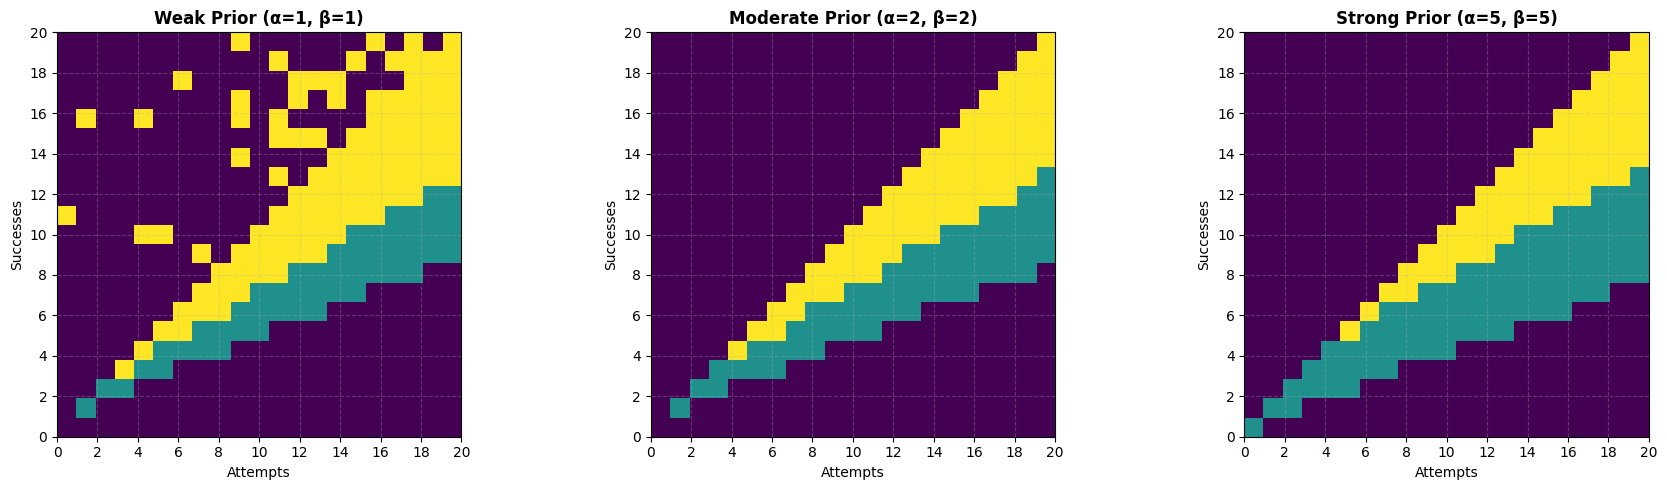

Comparison: Prior Strength Effect
  - Weak prior: Data has more influence, boundaries shift more
  - Strong prior: Prior has more influence, boundaries are more conservative
  - Moderate prior (our default): Balanced approach


In [17]:
# Compare weak vs strong priors
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

prior_configs = [
    {"alpha": 1.0, "beta": 1.0, "title": "Weak Prior (α=1, β=1)"},
    {"alpha": 2.0, "beta": 2.0, "title": "Moderate Prior (α=2, β=2)"},
    {"alpha": 5.0, "beta": 5.0, "title": "Strong Prior (α=5, β=5)"},
]

for idx, config in enumerate(prior_configs):
    # Build grid for this prior
    temp_grid = np.empty((max_attempts + 1, max_attempts + 1))
    for n in range(max_attempts + 1):
        for k in range(n + 1):
            alpha_post, beta_post = posterior_params(config["alpha"], config["beta"], n, k)
            low = ci_low(alpha_post, beta_post, confidence)
            if low >= proficient_threshold:
                temp_grid[n, k] = 2
            elif low >= familiar_threshold:
                temp_grid[n, k] = 1
            else:
                temp_grid[n, k] = 0
    
    # Plot
    ax = axes[idx]
    cmap = plt.get_cmap('viridis', 3)
    ax.imshow(temp_grid.T, origin='lower', extent=[0, max_attempts, 0, max_attempts], 
              aspect='equal', cmap=cmap, vmin=0, vmax=2)
    
    tick_step = 2
    ticks = np.arange(0, max_attempts + 1, tick_step)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlabel('Attempts', fontsize=10)
    ax.set_ylabel('Successes', fontsize=10)
    ax.set_title(config["title"], fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("Comparison: Prior Strength Effect")
print("=" * 60)
print("  - Weak prior: Data has more influence, boundaries shift more")
print("  - Strong prior: Prior has more influence, boundaries are more conservative")
print("  - Moderate prior (our default): Balanced approach")


## 3.10 Boundary Analysis

Let's analyze where the classification boundaries occur:


In [18]:
# Find boundary points (transitions between classifications)
print("Classification Boundaries")
print("=" * 80)

# Find transitions from Attempted to Familiar
attempted_to_familiar = []
for n in range(1, max_attempts + 1):
    for k in range(n + 1):
        if grid[n, k] == 1:  # Familiar
            # Check if previous (lower successes) was Attempted
            if k == 0 or grid[n, k-1] == 0:
                attempted_to_familiar.append((n, k))

# Find transitions from Familiar to Proficient
familiar_to_proficient = []
for n in range(1, max_attempts + 1):
    for k in range(n + 1):
        if grid[n, k] == 2:  # Proficient
            # Check if previous was Familiar
            if k == 0 or grid[n, k-1] == 1:
                familiar_to_proficient.append((n, k))

print(f"\nAttempted → Familiar transitions (first few):")
for n, k in attempted_to_familiar[:10]:
    print(f"  {k} successes out of {n} attempts → {k/n:.1%} rate")

print(f"\nFamiliar → Proficient transitions (first few):")
for n, k in familiar_to_proficient[:10]:
    print(f"  {k} successes out of {n} attempts → {k/n:.1%} rate")

print("\n" + "=" * 80)
print("\nPattern Analysis:")
print("  - Boundaries form diagonal lines")
print("  - More attempts → lower success rate needed for same classification")
print("  - This reflects increasing confidence with more data")


Classification Boundaries

Attempted → Familiar transitions (first few):
  1 successes out of 1 attempts → 100.0% rate
  2 successes out of 2 attempts → 100.0% rate
  2 successes out of 3 attempts → 66.7% rate
  3 successes out of 4 attempts → 75.0% rate
  3 successes out of 5 attempts → 60.0% rate
  3 successes out of 6 attempts → 50.0% rate
  4 successes out of 7 attempts → 57.1% rate
  4 successes out of 8 attempts → 50.0% rate
  5 successes out of 9 attempts → 55.6% rate
  5 successes out of 10 attempts → 50.0% rate

Familiar → Proficient transitions (first few):
  4 successes out of 4 attempts → 100.0% rate
  5 successes out of 5 attempts → 100.0% rate
  5 successes out of 6 attempts → 83.3% rate
  6 successes out of 7 attempts → 85.7% rate
  7 successes out of 8 attempts → 87.5% rate
  7 successes out of 9 attempts → 77.8% rate
  8 successes out of 10 attempts → 80.0% rate
  8 successes out of 11 attempts → 72.7% rate
  9 successes out of 12 attempts → 75.0% rate
  10 successes o

## 3.11 Summary: Understanding the Mastery Map

Let's summarize the key insights from the mastery map:

### What the Map Shows

1. **Classification Regions**: Three distinct regions for each mastery level
2. **Sample Size Effect**: Diagonal bands show how more attempts improve classifications
3. **Uncertainty Visualization**: The map visually represents how uncertainty decreases with more data

### Key Patterns

- **Triangular Shape**: Reflects the constraint that successes ≤ attempts
- **Diagonal Bands**: Show that higher classifications require better performance or more attempts
- **Boundary Curves**: The transition lines between classifications

### Practical Applications

- **Curriculum Design**: Understand how many attempts students typically need
- **Threshold Tuning**: See how changing thresholds affects classifications
- **Progress Tracking**: Visualize student progress across the map
- **System Design**: Inform decisions about how many attempts to require

### Interpreting Results

When looking at a mastery map:
1. **Bottom-left (purple)**: Low performance or very few attempts → "Attempted"
2. **Middle (teal)**: Moderate performance → "Familiar"
3. **Top-right (yellow)**: High performance with sufficient attempts → "Proficient"

**Remember**: The classification depends on BOTH the success rate AND the number of attempts!


## 3.12 Next Steps

You've now completed all three notebooks covering:

1. **Notebook 1**: Understanding the Beta–Binomial model
2. **Notebook 2**: Classifying groups using the model
3. **Notebook 3**: Visualizing the classification boundaries

### Putting It All Together

The mastery map is a powerful tool that:
- **Summarizes** the entire classification system in one visual
- **Guides** parameter selection and threshold tuning
- **Helps** understand the relationship between data and classifications
- **Supports** decision-making in adaptive learning systems

### Further Exploration

- Try different prior parameters and see how the map changes
- Experiment with different thresholds
- Adjust the confidence level and observe the effects
- Use the map to inform your educational design choices

**The mastery map is your guide to understanding how the Beta–Binomial classifier will behave across all possible outcomes!**
